1. Background of Project
2. Hypotheses
3. Summary of Findings and Insights
4. Data Acquisition and Prep
5. Exploratory Data Analysis
6. Feature Engineering
7. Modeling
8. Evaluation

Notes:
- Image use footnote
    - PBS KIDS and the PBS KIDS Logo are registered trademarks of PBS. Used with permission. The contents of PBS KIDS Measure Up! were developed under a grant from the Department of Education. However, those contents do not necessarily represent the policy of the Department of Education, and you should not assume endorsement by the Federal Government. The app is funded by a Ready To Learn grant (PR/AWARD No. U295A150003, CFDA No. 84.295A) provided by the Department of Education to the Corporation for Public Broadcasting.

# Child Learning and Development with PBS KIDS Measure Up! App

![title](mu_image.jpeg)

## I. BACKGROUND

### MEASURE UP! APP  
The PBS KIDS Measure Up! app is designed for children ages 3-5 to develop their comprehension of early STEM concepts. The app takes users on an adventure through three worlds: 
   - **Magma Peak** focuses on capacity and displacement
   - **Crystal Caves** focus is about weight
   - **Treetop City** teaches the concepts of length and height.

### 2019 KAGGLE DATA SCIENCE BOWL COMPETITION PRESENTED BY PBS KIDS & BOOZ ALLEN HAMILTON
This year's competition is focused on early childhood education through multimedia learning. Anonymized Measure Up! gameplay data was provided by PBS KIDS. The end product of each submission is to provide a model that predicts the accuracy group of users.

Accuracy group is based on the number of attempts a user makes until s/he completes the "challenge" (a.k.a. assessment). Based on user's performance on each completed assessment, an accuracy group is assigned:
 - 3 - Successfully completed the assessment on 1 attempt
 - 2 - Completed assessment on 2 attempts
 - 1 - Completed assessment on 3 attempts
 - 0 - Completed assessment on more than 3 attempts

The model will help PBS KIDS to improve game design and to discover relationships on game engagement and learning processes.

### THE PROJECT
The project is inspired by 2019's Kaggle Data Science Bowl. By analyzing data publicly provided by PBS KIDS on Kaggle, our team has sought to identify and understand drivers of children’s success on assessments (a.k.a. "challenges") in the app. The insights inform teachers and parents on how well using the different activities in the application prepare 3-5-year old children for the application’s final assessments.

A presentation documenting our findings and recommendations is delivered on Jan 30, 2020.

### PROBLEM STATEMENTS & HYPOTHESES:

**Problem 1:** What are the drivers of users assessment accuracy?  
**Hypothesis:** Users will show improvement with more engagement.
  
**Problem 2:** Is there a certain path that better prepare users in assessments - with the two paths being, linear progression and random (choose activities at their own will)  
**Hypothesis:** There is no difference in the performance between users who followed a linear progression and those who had random learning path.

> Linear Progression and their corresponding in-game activities are as follows:  
**Exposure** (video clip) → **Exploration** (activity) → **Practice** (game) → **Demonstration** (assessment)

### SUMMARY OF FINDINGS AND INSIGHTS

### CONCLUSION AND RECOMMENDATION




---

## II. MODULES & LIBRARIES

In [1]:
import pandas as pd
import numpy as np

#viz
import matplotlib.pyplot as plt
import seaborn as sns

#feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV

#modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import RFE


---
## III. DATA ACQUISITION & PREP

- Get csv files from: https://www.kaggle.com/c/data-science-bowl-2019/data
    - train.csv
    - train_labels.csv
    - test.csv

In [ ]:
train = pd.read_csv('train.csv')

In [ ]:
train_labels = pd.read_csv('train_labels.csv')

Look at the shape of train and train_labels dataframe

In [ ]:
train.shape

In [ ]:
train_labels.shape

Look at how many installation_ids are in each dataframe.

In [ ]:
train.installation_id.nunique()

In [ ]:
train_labels.installation_id.nunique()

How many installation id's are the same in each dataframe?

In [ ]:
train[train.installation_id.isin(train_labels.installation_id.unique())].installation_id.nunique()

Merge df, and train_labels together on installation_id. This will match our target variable 'accuracy_group' to their installation_ids.

In [ ]:
df = train[train.installation_id.isin(train_labels.installation_id.unique())]

In [ ]:
# Look at the shape of the new df.
df.shape

In [ ]:
11341042 - 7734558

We reduced our df by 3.6 million rows!!

Look at how many unique installation_ids are in the new df.

In [ ]:
df.installation_id.nunique()

How many students overall took assessments?

In [ ]:
train_labels.installation_id.nunique()/train.installation_id.nunique() 

In [ ]:
df1 = pd.merge(df, train_labels, on = 'game_session', how = 'left')

In [ ]:
df1.shape

In [ ]:
df1.columns

In [ ]:
df1.drop(columns = ['installation_id_y', 'title_y', 'title_x'], inplace = True)

In [ ]:
df1.rename(columns = {'installation_id_x': 'installation_id'}, inplace = True)

In [ ]:
# Turn timestamp into datatime format
df['timestamp'] = pd.to_datetime(df.timestamp)

#### Evaluate how many assessments each user completes.

In [ ]:
df1[df1.type == 'Assessment'].accuracy_group.value_counts(dropna=False)

Drop the NaN accuracy_group rows.

In [ ]:
# capture the index values of NaN assessments
na_assessments = df1[(df1.type == 'Assessment') & (df1.accuracy_group.isna())].index

In [ ]:
# make sure all of the NaN assessments are captured.
len(na_assessments)

In [ ]:
df1.drop(na_assessments, inplace = True)

In [ ]:
#Check the shape of df1: 7734558 - 7696400 = 38158
df1.shape

In [ ]:
assessments = df1.groupby(['installation_id', 'game_session', 'accuracy_group']).count().reset_index()

In [ ]:
# Count how many times each user was in each accuracy_group. 
# Count how many assessments they took overall. 
# Drop the bottom 'All' ROW.
assessment_count = pd.crosstab(assessments.installation_id, assessments.accuracy_group, margins = True).drop('All')
assessment_count

In [ ]:
# Look at the overall distribution of how many assessments each user took.
assessment_count.All.describe()

In [ ]:
assessment_count.All.value_counts().sort_index()

In [ ]:
q1 = assessment_count.All.quantile(0.25)
q1

In [ ]:
q3 = assessment_count.All.quantile(0.75)
q3

In [ ]:
iqr = q3-q1
iqr

In [ ]:
upper_fence = q3 + 3*iqr
upper_fence

In [ ]:
assessment_count[assessment_count.All <= 21]

In [ ]:
df1[df1.installation_id.isin(assessment_count[assessment_count.All <= 21].index)].installation_id.nunique()

### Create a new dataframe that only contains installation_ids with <= 21 assessments

In [ ]:
# pd.read_csv('df_21.csv').shape

In [ ]:
df_21 = df1[df1.installation_id.isin(assessment_count[assessment_count.All <= 21].index)]

In [ ]:
df_21.shape

In [ ]:
assessments_21 = df_21.sort_values(by = ['installation_id', 'timestamp'])[df_21.type == 'Assessment']

In [ ]:
assessments_21.shape

Grab the last assessments from each installation id. These will be our final accuracy_group that we use as target variables in our model.

In [ ]:
assessments_21.drop_duplicates(subset = ['installation_id'], keep = 'last', inplace = True)

In [ ]:
assessments_21.shape

In [ ]:
last_assessments_index = assessments_21.index

In [ ]:
last_assessment_game_sessions = assessments_21.game_session.unique()
last_assessment_game_sessions

## Create a dataframe that does not contain the last game sessions.

In [ ]:
df_new = df_21[~df_21.game_session.isin(last_assessment_game_sessions)]

In [ ]:
df_new.shape

In [ ]:
df_new.installation_id.nunique()

In [ ]:
after_last_assessment_df = df_new[0:0]
for i in assessments_21.index:
    after_last_assessment_df = after_last_assessment_df.append(df_new[(df_new.installation_id == assessments_21.loc[i].installation_id) & (df_new.timestamp > assessments_21.loc[i].timestamp)])
    print(i)
    

In [ ]:
after_last_assessment_df.game_session.nunique()

In [ ]:
after_last_assessment_df.installation_id.nunique()

In [ ]:
df_new.drop(after_last_assessment_df.index).shape

In [ ]:
df_new['date'] = df_new['timestamp'].dt.date
df_new['hour'] = df_new['timestamp'].dt.hour
df_new['weekday'] = df_new['timestamp'].dt.weekday_name
df_new['game_mins'] = df_new.game_time/60_000

In [ ]:
# Write final df_new to csv to load and use after 
# df_new.to_csv('train_maybe_final')

In [ ]:
df_test = pd.read_csv('train_maybe_final.csv')

In [ ]:
df_test.shape

---
## IV. EXPLORATORY DATA ANALYSIS 

### Feature Engineering

In [2]:
df = pd.read_csv("train_maybe_final.csv")

In [3]:
df['game_mins'] = df.game_time/60_000

In [4]:
df['timestamp'] = pd.to_datetime(df.timestamp)

In [5]:
df.installation_id.nunique()

3485

In [6]:
assessment = df[df.type == "Assessment"]

#### 1) MAX CEILING - Accuracy Score

In [7]:
mc = assessment.groupby(["installation_id","game_session"])[["accuracy"]].max().sort_values(by=["installation_id","accuracy"],ascending=False).reset_index()
mc = mc.drop_duplicates(subset="installation_id",keep="first")

max_ceiling = mc[["installation_id","accuracy"]].set_index("installation_id").rename(columns={"accuracy":"max_ceiling"})

In [8]:
max_ceiling.shape

(2496, 1)

#### 2) MAX CEILING - Accuracy Group

In [9]:
max_group = df[df.type == "Assessment"].groupby(["installation_id","game_session"])[['accuracy_group']].max().sort_values(by=["installation_id","accuracy_group"],ascending=False).reset_index()
max_group = max_group.drop_duplicates(subset="installation_id",keep="first")
max_group = max_group[["installation_id","accuracy_group"]].set_index("installation_id").rename(columns={"accuracy_group":"max_group"})
max_group.shape

(2496, 1)

#### 3) LOWEST - Accuracy Score

In [10]:
ls = assessment.groupby(["installation_id","game_session"])[["accuracy"]].min().sort_values(by=["installation_id","accuracy"],ascending=True).reset_index()
ls = ls.drop_duplicates(subset="installation_id",keep="first")

lowest_score = ls[["installation_id","accuracy"]].set_index("installation_id").rename(columns={"accuracy":"low_score"})

In [11]:
lowest_score.shape

(2496, 1)

#### 4) LOWEST - Accuracy Group

In [12]:
min_group = df[df.type == "Assessment"].groupby(["installation_id","game_session"])[['accuracy_group']].min().sort_values(by=["installation_id","accuracy_group"]).reset_index()
min_group = min_group.drop_duplicates(subset="installation_id",keep="first")
min_group = min_group[["installation_id","accuracy_group"]].set_index("installation_id").rename(columns={"accuracy_group":"min_group"})
min_group.shape

(2496, 1)

#### 5) MEDIAN - Accuracy Score

In [13]:
md = assessment.groupby(["installation_id","game_session"])[["accuracy"]].median().sort_values(by=["installation_id","accuracy"]).reset_index()
md = md.drop_duplicates(subset="installation_id",keep="first")

median_score = md[["installation_id","accuracy"]].set_index("installation_id").rename(columns={"accuracy":"median_score"})

In [14]:
median_score.shape

(2496, 1)

#### 6) MEDIAN - Accuracy Group

In [15]:
median_accuracy_group = df[df.type == "Assessment"].groupby(["installation_id","game_session"])[['accuracy_group']].median().reset_index().sort_values(by=["installation_id","accuracy_group"],ascending=False)
median_accuracy_group = median_accuracy_group.groupby(['installation_id'])[['accuracy_group']].median().rename(columns = {'accuracy_group': 'median_group'})
median_accuracy_group.head()

,median_group
installation_id,
0006a69f,2.5
0006c192,1.5
001d0ed0,2.5
002db7e3,2.0
003372b0,3.0


#### 7) NUMBER OF ACTIONS - Assessments

In [16]:
actions = assessment.groupby(['installation_id','game_session'])[['event_id']].count().reset_index().groupby("installation_id").sum().reset_index()

actions = actions[["installation_id","event_id"]].set_index("installation_id").rename(columns={"event_id":"no_actions"})

In [17]:
actions.shape

(2496, 1)

#### 8) NUMBER OF INCORRECT

In [18]:
no_incorrect = assessment.groupby(['installation_id','game_session'])[['num_incorrect']].count().reset_index().groupby("installation_id").sum()

In [19]:
no_incorrect.shape

(2496, 1)

#### 9) ACCURACY TENDENCY

In [20]:
tendency = assessment.groupby(['installation_id','game_session',"accuracy"])[['accuracy']].count().rename(columns={"accuracy":"acc"}).sort_values(by=["installation_id","acc"],ascending=False).reset_index()

tendency = tendency.drop_duplicates(subset="installation_id",keep="first")
tendency = tendency[["installation_id","accuracy"]]

In [21]:
condition_list = [tendency.accuracy == 0, tendency.accuracy == 0.5,tendency.accuracy == 1, (~tendency.accuracy.isin([0,1,0.5]))]
choice_list = ["low_scorer","avg_scorer","high_scorer","random_scorer"]

tendency["group"] = np.select(condition_list,choice_list,0)

In [22]:
tendency = pd.get_dummies(tendency,columns=["group"], prefix="tendency")
tendency = tendency[['installation_id','tendency_avg_scorer','tendency_high_scorer', 'tendency_low_scorer','tendency_random_scorer']].set_index("installation_id")

In [23]:
tendency.shape

(2496, 4)

In [24]:
# qu = max_ceiling.join([lowest_score,median_score,actions,no_incorrect,tendency])

In [25]:
# qu.head()

#### 10) NUMBER OF ASSESSMENTS PER WORLD

In [26]:
assessment_worlds = df[df.type == 'Assessment'].groupby(['installation_id', 'game_session','world']).count()[['event_id']].reset_index()
assessment_worlds = pd.crosstab(assessment_worlds.installation_id, assessment_worlds.world).rename(columns = {'CRYSTALCAVES': 'assesments_CC', 'MAGMAPEAK': 'assessments_MP', 'TREETOPCITY': 'Assessments_TTC'})
assessment_worlds.head()

world,assesments_CC,assessments_MP,Assessments_TTC
installation_id,,,
0006a69f,0,0,4
0006c192,0,1,1
001d0ed0,1,0,3
002db7e3,3,1,4
003372b0,3,0,2


#### 11) COUNT OF ACCURACY GROUPS

In [27]:
accuracy_groups = df[df.type =='Assessment'].groupby(['installation_id','game_session','type','accuracy_group']).count()[['event_id']].reset_index()
accuracy_groups.head()

,installation_id,game_session,type,accuracy_group,event_id
0,0006a69f,6bdf9623adc94d89,Assessment,3.0,35
1,0006a69f,77b8ee947eb84b4e,Assessment,0.0,87
2,0006a69f,901acc108f55a5a1,Assessment,3.0,48
3,0006a69f,9501794defd84e4d,Assessment,2.0,42
4,0006c192,197a373a77101924,Assessment,3.0,24


In [28]:
accuracy_group_count = pd.crosstab(accuracy_groups.installation_id, accuracy_groups.accuracy_group)
accuracy_group_count.head()

accuracy_group,0.0,1.0,2.0,3.0
installation_id,,,,
0006a69f,1,0,1,2
0006c192,1,0,0,1
001d0ed0,1,0,1,2
002db7e3,2,1,2,3
003372b0,1,0,1,3


#### 12) COUNT OF ENGAGEMENT TYPES

In [29]:
types = df.groupby(['installation_id', 'game_session', 'type']).count().reset_index()[['installation_id', 'game_session', 'type']]
types.head()

,installation_id,game_session,type
0,0006a69f,0336db4dee65ad4b,Game
1,0006a69f,05921a6eb858eeba,Activity
2,0006a69f,09fd0cc02e6ee5f4,Clip
3,0006a69f,1623f262016185e4,Game
4,0006a69f,1dd51df3dd28e7e0,Clip


In [30]:
type_count = pd.crosstab(types.installation_id, types.type)
type_count.shape

(3485, 4)

In [31]:
type_count.head()

type,Activity,Assessment,Clip,Game
installation_id,,,,
0006a69f,10,4,28,13
0006c192,8,2,30,6
001d0ed0,1,4,19,3
00225f67,3,0,10,3
00279ac5,10,0,21,11


#### 13) AVERAGE NUMBER OF ACTIONS - ALL ENGAGEMENT TYPE

In [32]:
average_no_actions = df.groupby(['installation_id','game_session'])[['event_id']].count().reset_index().groupby(['installation_id'])[['event_id']].mean().rename(columns = {'event_id': 'avg_no_actions'})
average_no_actions.shape

(3485, 1)

#### 14) NUMBER OF VISITS TO EACH WORLD

In [33]:
worlds = df.groupby(['installation_id','game_session','world']).count()[['event_id']].reset_index()
world_visits = pd.crosstab(worlds.installation_id, worlds.world)
world_visits.shape

(3485, 4)

#### 15) NUMBER OF MINUTES IN EACH ENGAGEMENT TYPE

In [34]:
game_time_group = df.groupby(['installation_id', 'game_session', 'type','date','weekday'])[['game_mins']].max().reset_index()

In [35]:
agg = game_time_group.groupby(['installation_id', 'type'])[['game_mins']].sum()

In [36]:
agg = agg.reset_index()

In [37]:
game_minutes = agg.pivot(index = 'installation_id', columns = 'type', values = 'game_mins')

In [38]:
game_minutes.fillna(0, inplace= True)

In [39]:
game_minutes.head()

type,Activity,Assessment,Clip,Game
installation_id,,,,
0006a69f,40.428983,3.187867,0.0,21.988250
0006c192,20.175500,1.771617,0.0,8.834550
001d0ed0,0.477983,2.609250,0.0,4.459850
00225f67,3.612000,0.000000,0.0,5.462883
00279ac5,25.135867,0.000000,0.0,50.541133


In [40]:
game_minutes.columns

Index(['Activity', 'Assessment', 'Clip', 'Game'], dtype='object', name='type')

In [41]:
game_minutes.columns = ['activity_mins', 'assessment_mins','clip_mins', 'game_mins']

In [42]:
game_minutes.head()

,activity_mins,assessment_mins,clip_mins,game_mins
installation_id,,,,
0006a69f,40.428983,3.187867,0.0,21.988250
0006c192,20.175500,1.771617,0.0,8.834550
001d0ed0,0.477983,2.609250,0.0,4.459850
00225f67,3.612000,0.000000,0.0,5.462883
00279ac5,25.135867,0.000000,0.0,50.541133


In [43]:
game_minutes.shape

(3485, 4)

#### 16) Number of Minutes in Assessments by Median, Mean, Min, Max

In [44]:

assess = df[df.type == 'Assessment']

In [45]:
groups = assess.groupby(['title', 'accuracy_group'])[['installation_id']].count().reset_index()

In [46]:
groups.columns = ['title', 'accuracy_group', 'users']
groups.head()

,title,accuracy_group,users
0,Bird Measurer (Assessment),0.0,32002
1,Bird Measurer (Assessment),1.0,43559
2,Bird Measurer (Assessment),2.0,13192
3,Bird Measurer (Assessment),3.0,20067
4,Cart Balancer (Assessment),0.0,17796


In [47]:
# 16) make median dataframe
med = assess.groupby(['installation_id', 'title'])[['accuracy']].median()

In [48]:
med.reset_index(inplace = True)

In [49]:
med_title = med.pivot(index = 'installation_id', columns = 'title', values = 'accuracy')

In [50]:
med_title.fillna(value = 0, inplace = True)

In [51]:
# med_title.reset_index(inplace = True)

In [52]:
med_title.columns = ['bird_med', 'cart_med', 'cauld_med', 'chest_med', 'shroom_med']

In [53]:
med_title.head()

,bird_med,cart_med,cauld_med,chest_med,shroom_med
installation_id,,,,,
0006a69f,0.000000,0.0,0.0,0.0,1.0
0006c192,0.000000,0.0,1.0,0.0,0.0
001d0ed0,0.000000,1.0,0.0,0.0,0.5
002db7e3,0.090909,1.0,1.0,0.0,0.5
003372b0,0.500000,1.0,0.0,0.0,1.0


In [54]:
# 17) create mean dataframe
mean_ = assess.groupby(['installation_id', 'title'])[['accuracy']].mean()
mean_.reset_index(inplace = True)

mean_title = mean_.pivot(index = 'installation_id', columns = 'title', values = 'accuracy')


mean_title.fillna(0, inplace = True)


In [55]:
# mean_title.reset_index(inplace = True)
mean_title.head()

title,Bird Measurer (Assessment),Cart Balancer (Assessment),Cauldron Filler (Assessment),Chest Sorter (Assessment),Mushroom Sorter (Assessment)
installation_id,,,,,
0006a69f,0.000000,0.0,0.0,0.0,0.832000
0006c192,0.000000,0.0,1.0,0.0,0.000000
001d0ed0,0.000000,1.0,0.0,0.0,0.683168
002db7e3,0.227273,1.0,1.0,0.0,0.723529
003372b0,0.500000,1.0,0.0,0.0,1.000000


In [56]:
mean_title.columns = ['bird_mean', 'cart_mean', 'cauld_mean', 'chest_mean','shroom_mean']

mean_title.head()

,bird_mean,cart_mean,cauld_mean,chest_mean,shroom_mean
installation_id,,,,,
0006a69f,0.000000,0.0,0.0,0.0,0.832000
0006c192,0.000000,0.0,1.0,0.0,0.000000
001d0ed0,0.000000,1.0,0.0,0.0,0.683168
002db7e3,0.227273,1.0,1.0,0.0,0.723529
003372b0,0.500000,1.0,0.0,0.0,1.000000


In [57]:
# 18) Create min df
min_ = assess.groupby(['installation_id', 'title'])[['accuracy']].min()

min_.reset_index(inplace = True)

min_title = min_.pivot(index = 'installation_id', columns = 'title', values = 'accuracy')

min_title.fillna(0, inplace = True)

# min_title.reset_index(inplace = True)

min_title.columns = ['bird_min', 'cart_min', 'cauld_min', 'chest_min', 'shroom_min']
min_title.head()

,bird_min,cart_min,cauld_min,chest_min,shroom_min
installation_id,,,,,
0006a69f,0.000000,0.0,0.0,0.0,0.5
0006c192,0.000000,0.0,1.0,0.0,0.0
001d0ed0,0.000000,1.0,0.0,0.0,0.5
002db7e3,0.090909,1.0,1.0,0.0,0.5
003372b0,0.500000,1.0,0.0,0.0,1.0


In [58]:
# 19) create max dataframe
max_ = assess.groupby(['installation_id', 'title'])[['accuracy']].max()

max_.reset_index(inplace = True)

max_title = max_.pivot(index = 'installation_id', columns = 'title', values = 'accuracy')

max_title.fillna(0, inplace = True)

# max_title.reset_index(inplace = True)

max_title.columns = ['bird_max', 'cart_max', 'cauld_max', 'chest_max', 'shroom_max']
max_title.head()

,bird_max,cart_max,cauld_max,chest_max,shroom_max
installation_id,,,,,
0006a69f,0.0,0.0,0.0,0.0,1.0
0006c192,0.0,0.0,1.0,0.0,0.0
001d0ed0,0.0,1.0,0.0,0.0,1.0
002db7e3,0.5,1.0,1.0,0.0,1.0
003372b0,0.5,1.0,0.0,0.0,1.0


### Merge data frames together to create dataframe that will go into the model.



In [59]:
last_assessments = pd.read_csv('last_assessments.csv')
last_assessments.set_index('installation_id', inplace = True)
last_assessments.rename(columns = {'accuracy_group': 'last_accuracy_group'}, inplace = True)

In [60]:
last_assessments[['last_accuracy_group']]

,last_accuracy_group
installation_id,
0006a69f,3.0
0006c192,2.0
00129856,3.0
001d0ed0,0.0
00225f67,0.0
00279ac5,0.0
002db7e3,1.0
003372b0,3.0
004c2091,0.0


In [61]:
beta = last_assessments[['last_accuracy_group']].join([max_ceiling, 
                       max_group, 
                       lowest_score, 
                       min_group, 
                       median_score, 
                       median_accuracy_group, 
                       actions, 
                       tendency, 
                       assessment_worlds, 
                       accuracy_group_count, 
                       type_count, 
                       average_no_actions, 
                       world_visits,
                       game_minutes,                                
                       mean_title, 
                       med_title, 
                       min_title, 
                       max_title]).fillna(0)

In [62]:
beta.shape

(3523, 52)

In [63]:
beta.columns

Index([   'last_accuracy_group',            'max_ceiling',
                    'max_group',              'low_score',
                    'min_group',           'median_score',
                 'median_group',             'no_actions',
          'tendency_avg_scorer',   'tendency_high_scorer',
          'tendency_low_scorer', 'tendency_random_scorer',
                'assesments_CC',         'assessments_MP',
              'Assessments_TTC',                      0.0,
                            1.0,                      2.0,
                            3.0,               'Activity',
                   'Assessment',                   'Clip',
                         'Game',         'avg_no_actions',
                 'CRYSTALCAVES',              'MAGMAPEAK',
                         'NONE',            'TREETOPCITY',
                'activity_mins',        'assessment_mins',
                    'clip_mins',              'game_mins',
                    'bird_mean',              'cart_mean

In [68]:
beta.shape

(3523, 53)

In [64]:
# Create a column to map values in last_accuracy_group to accuracy_group 3 or not a 3.

In [65]:
beta['last_accuracy_group1'] = beta.last_accuracy_group.map({3:1,2:0,1:0,0:0})

In [66]:
len(beta.columns)

53

In [67]:
beta.last_accuracy_group1.value_counts(normalize = True)

0    0.54868
1    0.45132
Name: last_accuracy_group1, dtype: float64

---
## V. TEST-TRAIN SPLIT & FEATURE ENGINEERING 

In [69]:
X_list = list(beta.columns)

In [70]:
X_list.remove('last_accuracy_group')
X_list.remove('last_accuracy_group1')

In [71]:
X = beta[X_list]
y = beta[['last_accuracy_group']]

Acquire "tidy" data frames with features and y for feature engineering.

In [ ]:
# Features on separate data frames
# qu = pd.read_csv("cris_df.csv")
# be = pd.read_csv("beta.csv")

In [ ]:
# qu.set_index("installation_id",inplace=True)
# be.set_index("installation_id",inplace=True)

In [ ]:
# print(f"shape:{be.shape}")
# be.head()

In [ ]:
# print(f"shape:{qu.shape}")
# qu.head()

#### SUBSETTING FOR BALANCED DATA

In [ ]:
# be.accuracy_group.value_counts().plot(kind="bar")

#### MERGING WITH BETA

In [ ]:
# features = be.join(qu,how="left").fillna(0)
# features = features.copy().drop(columns="accuracy_group")
# features.head()

In [ ]:
# features.shape

#### REMOVE NA_USERS ON TRAIN

In [ ]:
# na_users = list(features[features.max_ceiling.isna()].index)

In [ ]:
# features = features[~features.index.isin(na_users)]

In [ ]:
# Data Frame with accuracy group, i.e., the "y" or target
# y = pd.read_csv("last_assessments.csv")
# y = y[["installation_id","accuracy_group"]].set_index("installation_id")

# y = y[~y.index.isin(na_users)]

In [ ]:
# y.shape

In [ ]:
# print(f"Features Shape: {features.shape}")
# print(f"y Shape: {y.shape}")

In [ ]:
# y.accuracy_group.value_counts()

### Scale

In [ ]:
# scaler = StandardScaler()
# scaled_features = pd.DataFrame(scaler.fit_transform(be),columns=be.columns).set_index(be.index)

In [ ]:
# scaler = StandardScaler()
# scaled_features = pd.DataFrame(scaler.fit_transform(features),columns=features.columns).set_index(features.index)

In [ ]:
# scaled_features.head()

In [ ]:
# scaled_features.columns

In [ ]:
# df_feed = scaled_features.copy()

In [ ]:
# df_feed

### Train-Test Split

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y["last_accuracy_group"],random_state=123)

In [73]:
y_train.last_accuracy_group.value_counts()

3.0    1113
0.0     700
1.0     335
2.0     318
Name: last_accuracy_group, dtype: int64

In [74]:
X_test.shape

(1057, 51)

In [75]:
X_train.shape

(2466, 51)

### Recursive Feature Engineering

In [76]:
number_of_features_list=np.arange(1,52)
high_score=0

#Variable to store the optimum features
number_of_features=0           
score_list =[]

for n in range(0,len(number_of_features_list)):
    print(number_of_features_list[n])
    model = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=6, 
                            random_state=600)
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
Optimum number of features: 3
Score with 3 features: 0.496689


In [78]:
# Find the 39 selected features
cols = list(X_train.columns)
model = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=6, 
                            random_state=600)

#Initializing RFE model
rfe = RFE(model, 3)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['median_group', 'Clip', 'avg_no_actions'], dtype='object')


### Feature Engineering

In [ ]:
# lasso = LassoCV()
# lasso.fit(X_train, y_train)

In [ ]:
# print(f"Best alpha using built-in LassoCV: {lasso.alpha_}")
# print(f"Best score using built-in LassoCV: {lasso.score(X_train,y_train)}")

In [ ]:
# coef = pd.DataFrame(lasso.coef_, index = X_train.columns).rename(columns={0:"feature_weights"}).sort_values(by="feature_weights",ascending=False)

In [ ]:
# coef.head()

In [ ]:
# coef.plot(kind="barh",figsize=(15,12))

### Keep all non-zero features

In [ ]:
# weighted_coef = coef[coef.feature_weights != 0]

In [ ]:
#see if all zero-value features are removed
# weighted_coef.describe()

In [ ]:
# weighted_coef_list = list(weighted_coef.index)

In [ ]:
# X_train.head()

In [ ]:
# X_train = X_train[weighted_coef_list]
# X_test = X_test[weighted_coef_list]

In [ ]:
# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape: {X_test.shape}")

---
## VI. MODELING

In [79]:
# Create a model with selected features
X_list = list(selected_features_rfe)

In [80]:
X = beta[X_list]
y = beta[['last_accuracy_group']]

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y["last_accuracy_group"],random_state=123)

### Random Forest

Create Random Forest object.  
Fit Train data.

In [82]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=7, 
                            random_state=600)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=600,
                       verbose=0, warm_start=False)

Look at how the algorithm use features, that is, check feature importance.

In [83]:
rf_features = pd.DataFrame([rf.feature_importances_],columns = X_train.columns).T.rename(columns = {0: 'feature_importance'}).sort_values(by='feature_importance', ascending=False)

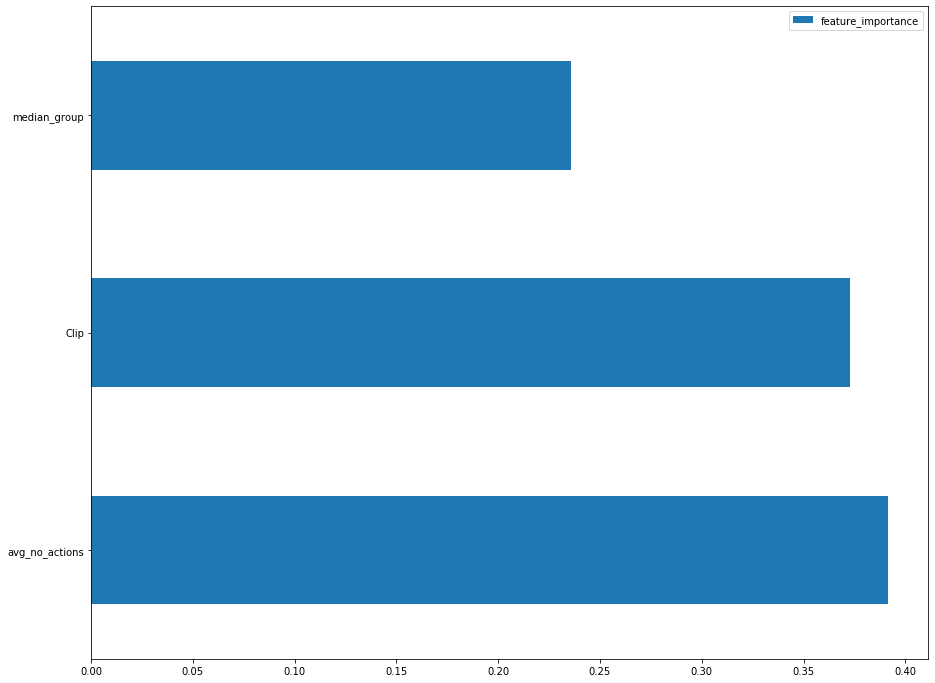

In [84]:
rf_features.plot(kind="barh",figsize=(15,12))

In [85]:
y_pred_train = pd.DataFrame(rf.predict(X_train),index = X_train.index)
y_pred_test = pd.DataFrame(rf.predict(X_test),index = X_test.index)

In [86]:
y_pred_train[0].value_counts()

3.0    1916
0.0     531
1.0      15
2.0       4
Name: 0, dtype: int64

In [87]:
y_pred_test[0].value_counts()

3.0    834
0.0    220
1.0      3
Name: 0, dtype: int64

In [88]:
predictions_0 = pd.DataFrame(rf.predict(X),index = X.index, columns = ['predicted0'])

In [89]:
predictions_0.head()

,predicted0
installation_id,
0006a69f,3.0
0006c192,3.0
00129856,3.0
001d0ed0,3.0
00225f67,0.0


In [90]:
beta = beta.join(predictions_0)
beta.shape

(3523, 54)

#### EVALUATION: RANDOM FOREST

In [91]:
print(f"RF Score for Train: {rf.score(X_train, y_train)}")
print(f"RF Score for Test: {rf.score(X_test, y_test)}")
print(f"RF Score for X: {rf.score(X, y)}")

RF Score for Train: 0.5442011354420113
RF Score for Test: 0.4853358561967833
RF Score for X: 0.5265398807834232


In [92]:
confusion_matrix(y_pred_test, y_test)

array([[107,  28,  16,  69],
       [  1,   0,   0,   2],
       [  0,   0,   0,   0],
       [192, 116, 120, 406]])

In [93]:
confusion_matrix(beta[['predicted0']], beta[['last_accuracy_group']])

array([[ 425,   89,   62,  175],
       [   1,   14,    1,    2],
       [   0,    1,    3,    0],
       [ 574,  375,  388, 1413]])

In [94]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

         0.0       0.36      0.49      0.41       220
         1.0       0.00      0.00      0.00         3
         2.0       0.00      0.00      0.00         0
         3.0       0.85      0.49      0.62       834

    accuracy                           0.49      1057
   macro avg       0.30      0.24      0.26      1057
weighted avg       0.75      0.49      0.57      1057



In [95]:
beta.last_accuracy_group.value_counts(normalize=True)

3.0    0.451320
0.0    0.283849
1.0    0.135964
2.0    0.128867
Name: last_accuracy_group, dtype: float64

# Create a Layer Model, First using accuracy_group1 in the Random Forest.
Is the accuracy_group going to be a three or not a three. (3:1 or not_a_3: 0)

In [96]:
X_list = list(beta.columns)

In [97]:
X_list.remove('last_accuracy_group')
X_list.remove('last_accuracy_group1')
X_list.remove('predicted0')

In [98]:
X = beta[X_list]
y = beta[['last_accuracy_group1']]

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y["last_accuracy_group1"],random_state=123)

# Recursive Feature Engineering ROUND 1 (LAYERING)


In [100]:
n = len(X_train.columns)

In [101]:
number_of_features_list=np.arange(1,n+1)
high_score=0

#Variable to store the optimum features
number_of_features=0           
score_list =[]

for n in range(len(number_of_features_list)):
    print(number_of_features_list[n])
    model = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=6, 
                            random_state=600)
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
Optimum number of features: 48
Score with 48 features: 0.624409


In [126]:
cols = list(X_train.columns)
model = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=6, 
                            random_state=600)

#Initializing RFE model
rfe = RFE(model, 48)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index([        'max_ceiling',           'low_score',           'min_group',
              'median_score',        'median_group',          'no_actions',
       'tendency_low_scorer',       'assesments_CC',      'assessments_MP',
           'Assessments_TTC',                   0.0,                   2.0,
                         3.0,            'Activity',          'Assessment',
                      'Clip',                'Game',      'avg_no_actions',
              'CRYSTALCAVES',           'MAGMAPEAK',                'NONE',
               'TREETOPCITY',       'activity_mins',     'assessment_mins',
                 'game_mins',           'bird_mean',           'cart_mean',
                'cauld_mean',          'chest_mean',         'shroom_mean',
                  'bird_med',            'cart_med',           'cauld_med',
                 'chest_med',          'shroom_med',            'bird_min',
                  'cart_min',           'cauld_min',           'chest_min',
            

# Create a Model with the Selected Features (ROUND 1)

In [127]:
X_list = list(selected_features_rfe)

In [128]:
X = beta[X_list]
y = beta[['last_accuracy_group1']]

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y["last_accuracy_group1"],random_state=123)

In [130]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=6, 
                            random_state=600)

In [131]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=600,
                       verbose=0, warm_start=False)

In [132]:
rf_features = pd.DataFrame([rf.feature_importances_],columns = X_train.columns).T.rename(columns = {0: 'feature_importance'}).sort_values(by='feature_importance', ascending=False)

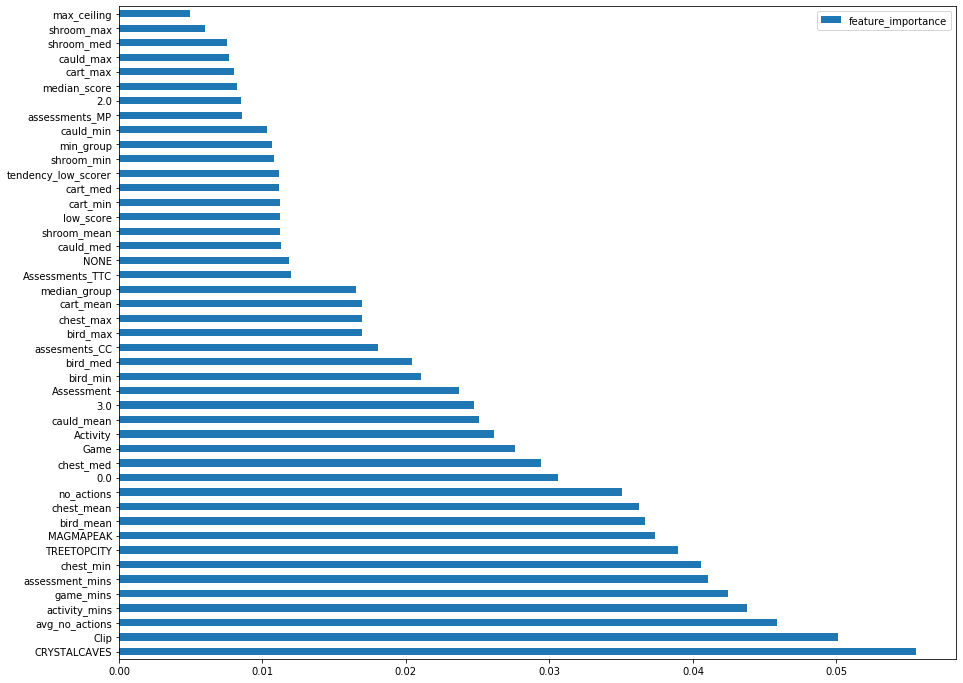

In [133]:
rf_features.plot(kind="barh",figsize=(15,12))

In [134]:
predictions_1 = pd.DataFrame(rf.predict(X),index = X.index, columns = ['predicted1'])

In [135]:
beta.shape

(3523, 54)

In [136]:
beta1 = beta.join(predictions_1)
beta1.shape

(3523, 55)

In [137]:
print(f"RF Score for Train: {rf.score(X_train, y_train)}")
print(f"RF Score for Test: {rf.score(X_test, y_test)}")
print(f"RF Score for X: {rf.score(X, y)}")

RF Score for Train: 0.6918085969180859
RF Score for Test: 0.6177861873226111
RF Score for X: 0.6695997729208061


In [138]:
pd.DataFrame(rf.predict(X_test),columns = ['X_test_predict']).X_test_predict.value_counts(normalize = True)

0    0.728477
1    0.271523
Name: X_test_predict, dtype: float64

## Use the predictions from rf.predict(X) to create the second grouping of installation_ids that were NOT predicted 3. 

In [139]:
beta2 = beta1[beta1.predicted1 == 0]
beta2.shape

(2545, 55)

In [140]:
beta2.last_accuracy_group.value_counts(normalize = True)

0.0    0.358350
3.0    0.348919
1.0    0.157171
2.0    0.135560
Name: last_accuracy_group, dtype: float64

In [141]:
X_list = list(beta2.columns)

In [142]:
X_list.remove('last_accuracy_group')
X_list.remove('last_accuracy_group1')
X_list.remove('predicted0')
X_list.remove('predicted1')

The target variable will be the last_accuracy_group to find if those that were NOT predicted a 3 the first round fall into group 0,1,2,3.

In [143]:
X = beta2[X_list]
y = beta2[['last_accuracy_group']]

Train_test_split over the 'last_accuracy_group' column.

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y["last_accuracy_group"],random_state=123)

In [145]:
n = len(X_train.columns)

In [146]:
number_of_features_list=np.arange(1,n+1)
high_score=0

#Variable to store the optimum features
number_of_features=0           
score_list =[]

for n in range(len(number_of_features_list)):
    print(number_of_features_list[n])
    model = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=6, 
                            random_state=600)
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
Optimum number of features: 2
Score with 2 features: 0.412304


In [148]:
cols = list(X_train.columns)
model = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=6, 
                            random_state=600)

#Initializing RFE model
rfe = RFE(model, 2)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['Clip', 'avg_no_actions'], dtype='object')


In [151]:
beta2.last_accuracy_group.value_counts(normalize = True)

0.0    0.358350
3.0    0.348919
1.0    0.157171
2.0    0.135560
Name: last_accuracy_group, dtype: float64

# Create a Model with the Selected Features (ROUND 2)

In [152]:
X_list = list(selected_features_rfe)

In [153]:
X = beta2[X_list]
y = beta2[['last_accuracy_group']]

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y["last_accuracy_group"],random_state=123)

In [155]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=6, 
                            random_state=600)

In [156]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=600,
                       verbose=0, warm_start=False)

In [157]:
rf_features = pd.DataFrame([rf.feature_importances_],columns = X_train.columns).T.rename(columns = {0: 'feature_importance'}).sort_values(by='feature_importance', ascending=False)

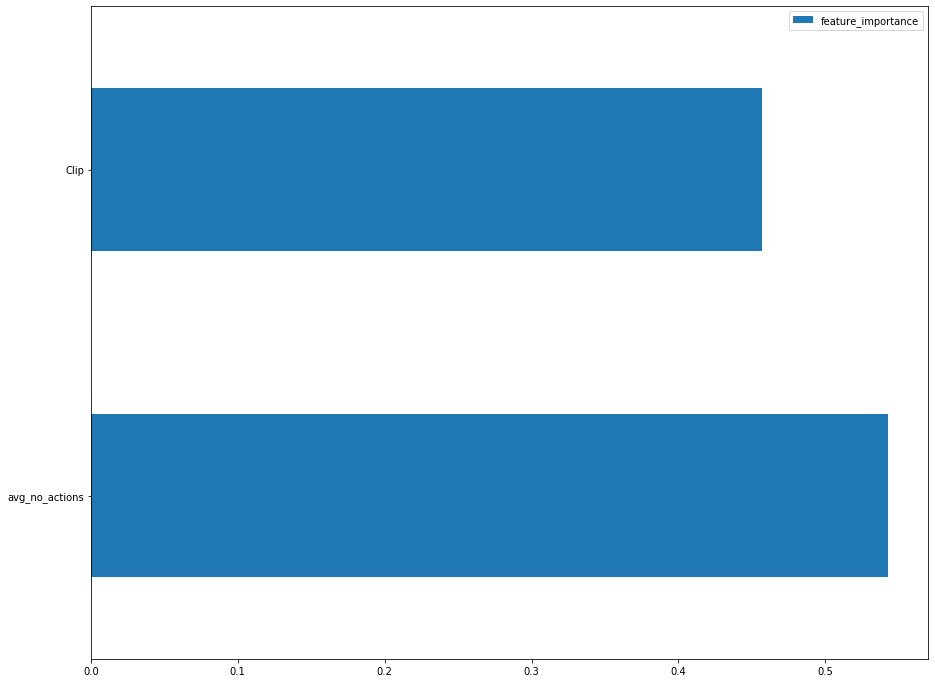

In [158]:
rf_features.plot(kind="barh",figsize=(15,12))

In [159]:
predictions_2 = pd.DataFrame(rf.predict(X),index = X.index, columns = ['predicted2'])

In [160]:
predictions_2.predicted2.value_counts()

3.0    1278
0.0    1258
2.0       6
1.0       3
Name: predicted2, dtype: int64

In [161]:
predictions_2.shape

(2545, 1)

In [162]:
beta.shape

(3523, 54)

In [163]:
beta3 = beta.join(predictions_2)
beta3.shape

(3523, 55)

In [164]:
print(f"RF Score for Train: {rf.score(X_train, y_train)}")
print(f"RF Score for Test: {rf.score(X_test, y_test)}")
print(f"RF Score for X: {rf.score(X, y)}")

RF Score for Train: 0.4862436833239753
RF Score for Test: 0.412303664921466
RF Score for X: 0.46404715127701374


In [165]:
pd.DataFrame(rf.predict(X_test),columns = ['X_test_predict']).X_test_predict.value_counts(normalize = True)

0.0    0.517016
3.0    0.481675
2.0    0.001309
Name: X_test_predict, dtype: float64

In [166]:
beta.shape

(3523, 54)

In [170]:
beta3.predicted2.value_counts(normalize=True, dropna=False)

3.0    0.362759
0.0    0.357082
NaN    0.277604
2.0    0.001703
1.0    0.000852
Name: predicted2, dtype: float64

In [171]:
beta3['predicted2'].fillna(3, inplace = True)

In [172]:
beta3.predicted2.value_counts(normalize = True, dropna = False)

3.0    0.640363
0.0    0.357082
2.0    0.001703
1.0    0.000852
Name: predicted2, dtype: float64

In [173]:
confusion_matrix(beta3['predicted2'], beta3['last_accuracy_group'])

array([[ 596,  185,  169,  308],
       [   0,    2,    1,    0],
       [   1,    2,    3,    0],
       [ 403,  290,  281, 1282]])

In [175]:
print(classification_report(beta3['predicted2'], beta3['last_accuracy_group']))

              precision    recall  f1-score   support

         0.0       0.60      0.47      0.53      1258
         1.0       0.00      0.67      0.01         3
         2.0       0.01      0.50      0.01         6
         3.0       0.81      0.57      0.67      2256

    accuracy                           0.53      3523
   macro avg       0.35      0.55      0.30      3523
weighted avg       0.73      0.53      0.62      3523



In [176]:
print(classification_report(beta3['predicted0'], beta3['last_accuracy_group']))

              precision    recall  f1-score   support

         0.0       0.42      0.57      0.49       751
         1.0       0.03      0.78      0.06        18
         2.0       0.01      0.75      0.01         4
         3.0       0.89      0.51      0.65      2750

    accuracy                           0.53      3523
   macro avg       0.34      0.65      0.30      3523
weighted avg       0.78      0.53      0.61      3523



### Logistic Regression

---

# Checking - to be removed

In [ ]:
from scipy import stats

#### DF THAT HAS TENDENCIES PER INSTALLATION ID

In [ ]:
assessment.head()

In [ ]:
# a_counts = assessment.groupby(["installation_id","game_session"]).agg(stats.mode)[["accuracy_group"]]
# # a_counts = a_counts.drop_duplicates(subset="installation_id",keep="first")

In [ ]:
a_counts = assessment.groupby(["installation_id","game_session"]).median()[["accuracy_group"]].reset_index().groupby(["installation_id"]).median()[["accuracy_group"]].reset_index()
# a_counts = a_counts.drop_duplicates(subset="installation_id",keep="first")

In [ ]:
a_counts.head()

In [ ]:
a_counts["tendency"

In [ ]:
a_counts = a_counts.drop_duplicates(subset="installation_id",keep="first")

In [ ]:
a_counts =

In [ ]:
a_counts[]

In [ ]:
assessment.groupby(["installation_id","accuracy_group","game_session"])[["game_session"]].sum()

#### HOW MUCH ARE THEY PLAYING AROUND BEFORE THEY HIT "DONE"/ATTEMPT

In [ ]:
assessment_sub = assessment[assessment.accuracy_group.isin([1,2])]

In [ ]:
assessment_sub.sample()

In [ ]:
assessment_sub["num_incorrect"].value_counts().plot(kind="bar")

In [ ]:
assessment_sub[["event_id","title"]]

In [ ]:
assessment_sub.groupby(["installation_id","game_session","event_id","accuracy"]).count()[["num_incorrect"]]

In [ ]:
assessment_sub.shape

In [ ]:
assessment_sub.accuracy_group.value_counts()

In [ ]:
assessment.num_correct.value_counts()

In [ ]:
assessment[assessment.installation_id == "baedce19"]

In [ ]:
assessment

---

In [ ]:
subset_12 = features.join(y)

In [ ]:
subset_12.head()

In [ ]:
subset_12 = subset_12[subset_12.accuracy_group.isin([1,2])]
subset_12.accuracy_group = np.where(subset_12.accuracy_group == 1, "one","two")

In [ ]:
subset_12[["Assessment","Clip","Game","Activity"]].sum().plot(kind="bar")

---

In [ ]:
X_subset_12 = subset_12.drop(columns="accuracy_group")

In [ ]:
y_subset_12 = subset_12[["accuracy_group"]]

In [ ]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=6, 
                            random_state=600)

rf.fit(X_subset_12, y_subset_12)

In [ ]:
subset12_features = pd.DataFrame([rf.feature_importances_],columns = X_subset_12.columns).T.rename(columns = {0: 'feature_importance'}).sort_values(by='feature_importance', ascending=False)

In [ ]:
subset12_features.plot(kind="barh",figsize=(15,12))

In [ ]:
print(f"RF Score for Train: {rf.score(X_subset_12, y_subset_12)}")